<a href="https://colab.research.google.com/github/dropthejase/ml_training/blob/main/neural_networks/cnn_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Add data augmentation**

In [2]:
transformer_train = torchvision.transforms.Compose([
    #torchvision.transforms.ColorJitter(
    #    brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomCrop(32, padding=4),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    #torchvision.transforms.RandomRotation(degrees=15),
    torchvision.transforms.RandomAffine(0, translate=(0.1, 0.1)),
    # torchvision.transforms.RandomPerspective(),
    transforms.ToTensor()
])

**LOAD DATASET**

In [3]:
train_dataset = torchvision.datasets.CIFAR10(
    root='.',
    train=True,
    transform=transformer_train,
    download=True
)

test_dataset = torchvision.datasets.CIFAR10(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


**DEFINE THE CLASS MODULE AND RUN IT**
This will be done slightly differently than last time - simply a different way, not better or worse

In [4]:
K = len(set(train_dataset.targets))
print(K)

10


In [5]:
batch_size = 120
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

In [6]:
tmp_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=1,
                                           shuffle=True)

for inputs, targets in tmp_loader:
  print(inputs.shape)
  break

# torch.Size([1, 3, 32, 32]) - note that N and C comes first - but PyTorch hides this by using DataLoaders

torch.Size([1, 3, 32, 32])


In [7]:
class CNN(nn.Module):
  def __init__(self, K):
    super(CNN, self).__init__()

    # define the conv layers
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2),
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2),
    )    
    
    self.conv3 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2),
    )        

    # define the linear layers
    self.fc1 = nn.Linear(128 * 4 * 4, 1024)
    self.fc2 = nn.Linear(1024, K)
 
  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = x.view(x.size(0), -1) # flatten image; -1 is inferred dimension
    x = F.dropout(x, p=0.5)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, p=0.2)
    x = self.fc2(x)
    return x

In [8]:
model = CNN(K)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel

In [10]:
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters())

In [11]:
def batch_gd(model, criterion, optimiser, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    model.train()
    train_loss = []
    for inputs, targets in train_loader:
      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradients
      optimiser.zero_grad()

      # forward pass
      outputs = model(inputs)

      # loss
      loss = criterion(outputs, targets)

      # train
      loss.backward()
      optimiser.step()

      train_loss.append(loss.item())

    # take mean loss of the batches
    train_loss = np.mean(train_loss)

    model.eval()
    test_loss = []
    for inputs, targets in test_loader:
      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # forward pass
      outputs = model(inputs)

      # loss
      loss = criterion(outputs, targets)
      
      test_loss.append(loss.item())

    # take mean loss of the batches
    test_loss = np.mean(test_loss)

    # save losses
    train_losses[it] += train_loss
    test_losses[it] += test_loss

    print(f'Epoch {it+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

  return train_losses, test_losses

In [12]:
train_losses, test_losses = batch_gd(model, criterion, optimiser, train_loader, test_loader, epochs=10)

Epoch 1, Train Loss: 1.4305, Test Loss: 1.0720
Epoch 2, Train Loss: 1.0307, Test Loss: 1.1803
Epoch 3, Train Loss: 0.8620, Test Loss: 0.8627
Epoch 4, Train Loss: 0.7693, Test Loss: 0.7657
Epoch 5, Train Loss: 0.6974, Test Loss: 0.6455
Epoch 6, Train Loss: 0.6535, Test Loss: 0.6631
Epoch 7, Train Loss: 0.6105, Test Loss: 0.6151
Epoch 8, Train Loss: 0.5761, Test Loss: 0.7202
Epoch 9, Train Loss: 0.5554, Test Loss: 0.5604
Epoch 10, Train Loss: 0.5322, Test Loss: 0.5268


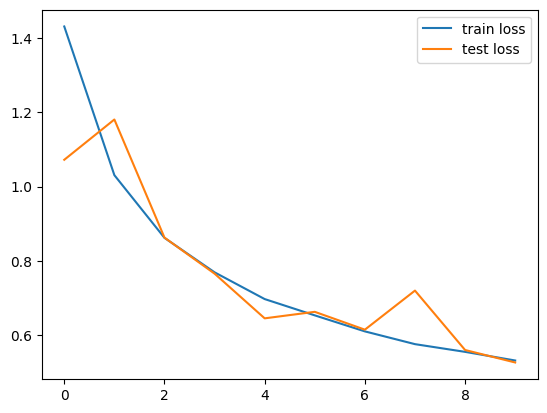

In [13]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

**ACCURACY & CONFUSION MATRIX**

In [14]:
model.eval()
n_correct = 0.
n_total = 0.

for inputs, targets in train_loader:
  inputs, targets = inputs.to(device), targets.to(device)

  outputs = model(inputs)

  _, predictions = torch.max(outputs, 1)


  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total

n_correct = 0.
n_total = 0.

for inputs, targets in test_loader:
  inputs, targets = inputs.to(device), targets.to(device)

  outputs = model(inputs)

  _, predictions = torch.max(outputs, 1)


  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total

print(f'Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}')

Train acc: 0.8326, Test acc: 0.8265


In [15]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [21]:
type(test_dataset.data)

numpy.ndarray

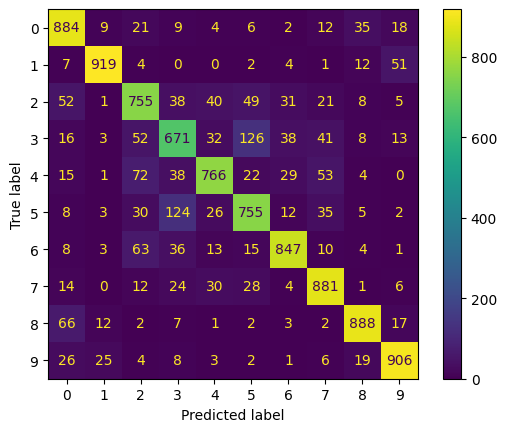

In [22]:
x_test = test_dataset.data
y_test = test_dataset.targets
p_test = np.array([])

for inputs, targets in test_loader:
  inputs, targets = inputs.to(device), targets.to(device)

  outputs = model(inputs)

  _, predictions = torch.max(outputs, 1)

  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()